<a href="https://www.kaggle.com/code/rupify/cifar10-pytorch?scriptVersionId=260138287" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/Rupkatha-dev/Task1-IIT-G-/blob/main/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

Load and Preprocess the CIFAR-10 Dataset

In [ ]:
# Transform: Convert to Tensor and Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
# Training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)


In [ ]:
# CIFAR-10 Classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Define the CNN Model

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)   
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)          

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)         
        self.fc2 = nn.Linear(512, 10)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))   
        x = self.pool(self.relu(self.conv2(x)))   
        x = x.view(-1, 64 * 8 * 8)                
        x = self.dropout(self.relu(self.fc1(x)))  
        x = self.fc2(x)                          
        return x

# Instantiate Model
net = CNN()

# Select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

net = net.to(device)

Define Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()        
optimizer = optim.Adam(net.parameters(), lr=0.001)


Train the CNN

In [ ]:
epochs = 5  

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

       
        optimizer.zero_grad()

        # Forward + Backward + Optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Training finshed")


Test the Model

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device) 
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy: {100 * correct / total:.2f}%")


Predict on Sample Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:7]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(7)))

outputs = net(images[:7].to(device))

#predicted labels
_, predicted = torch.max(outputs, 1)

print('Predicted:   ', ' '.join(f'{classes[predicted[j].item()]}' for j in range(7)))


Define AlexNet Model

In [ ]:
class alexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(alexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


alexnet= alexNet(num_classes=10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

alexnet = alexnet.to(device)


Define Loss Function and Optimize

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)


Train AlexNet

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet.parameters(), lr=0.001)

epochs = 5 
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}")

print("Training Finished ✅")


Test Accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = alexnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10000 test images: {100 * correct / total:.2f}%")


Prediction on Sample Images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(testloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images[:7]))

print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(7)))


outputs = alexnet(images[:7].to(device))


_, predicted = torch.max(outputs, 1)


print('Predicted:   ', ' '.join(f'{classes[predicted[j].item()]}' for j in range(7)))


Pre-Trained ResNet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchvision import models

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Data Preparation

In [4]:
# Resize to 224x224 for ResNet
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
batch_size = 64

# Train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 77.3MB/s] 


In [6]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Load Pre-trained ResNet

In [9]:
resnet = models.resnet18(pretrained=True)


num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 10)

resnet = resnet.to(device)

Define Loss Function and Optimizer

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

Train the Model

In [12]:
EPOCHS = 5

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print once per epoch
    avg_loss = running_loss / len(trainloader)
    print(f"[{epoch+1}] loss: {avg_loss:.3f}")

print("Finished Training ✅")


[1] loss: 0.277
[2] loss: 0.194
[3] loss: 0.150
[4] loss: 0.109
[5] loss: 0.090
Finished Training ✅


In [13]:
PATH = './resnet_cifar10.pth'
torch.save(resnet.state_dict(), PATH)

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on 10000 test images: {100 * correct / total:.2f}%")

Accuracy on 10000 test images: 90.10%


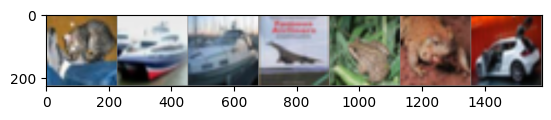

GroundTruth:  cat ship ship plane frog frog car frog cat car plane truck dog horse truck ship dog
Predicted:    cat ship ship plane frog frog car frog cat car plane truck dog horse truck frog dog


In [16]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random test images
dataiter = iter(testloader)
images, labels = next(dataiter)

# Show images (keep on CPU for matplotlib)
imshow(torchvision.utils.make_grid(images[:7]))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(17)))

# Move images to GPU for prediction
outputs = resnet(images[:17].to(device))
_, predicted = torch.max(outputs, 1)

# Print predicted labels
print('Predicted:   ', ' '.join(f'{classes[predicted[j].item()]}' for j in range(17)))